# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
import subprocess
from IPython.display import display, Markdown, HTML

suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [3]:
from data_processing import load_data

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 12 Feb 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on

population_subgroups = {"80+":"community_ageband",
        "70-79":"community_ageband", 
        "care home":"community_ageband", 
        "shielding":"shielded", 
        "under 70s, not in other eligible groups shown":"other"
        }

groups = population_subgroups.keys()

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {"other":    ["sex","ageband", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories",
                              "bmi","chronic_cardiac_disease", "current_copd", "dialysis", "dmards","ssri"],
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding": ["sex", "ageband", "ethnicity_6_groups", "imd_categories"],
                 "DEFAULT":   ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                              "psychosis_schiz_bipolar","intel_dis_incl_downs_syndrome","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

### Cumulative vaccination figures - overall

In [12]:
from report_results import make_vaccine_graphs

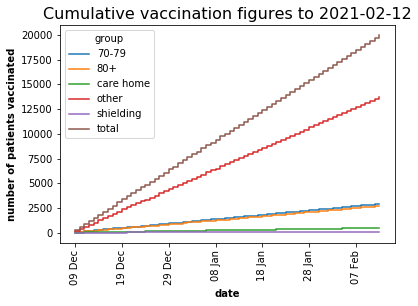

In [13]:
make_vaccine_graphs(df, latest_date=latest_date, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [14]:
from report_results import summarise_data_by_group

In [15]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [16]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [17]:
summ_stat_results = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, savepath=savepath, suffix=suffix)

In [18]:
# display the results of the summary stats in notebook
for x in summ_stat_results.keys():
    display(Markdown(f"{x}: {summ_stat_results[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

### As at 12 Feb 2021: 

**Total** population vaccinated in TPP: 19,999

**80+** population vaccinated: 2,730 (39.8% of 6,846)

**70-79** population vaccinated: 2,919 (39.8% of 7,331)

**care home** population vaccinated: 490 (43.1% of 1,129)

**shielding** population vaccinated: 154 (35.7% of 434)

**under 70s, not in other eligible groups shown** population vaccinated: 13,755

#### Vaccine types and second doses: 

Second doses (% of all vaccinated): 4,998 (25.0%)

Oxford-AZ vaccines (% of all first doses): 7 (0.0%)

*
 figures rounded to nearest 7

# Detailed summary of uptake among population groups as at latest date

In [19]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, savepath=savepath)

## 

## COVID vaccination rollout among **80+** population up to 12 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                  2728.0   
sex                           F                                        1379.0   
                              M                                        1351.0   
ageband_5yr                   0                                         182.0   
                              0-15                                      161.0   
                              16-29                                     182.0   
                              30-34                                     168.0   
                              35-39                                     161.0   
                              40-44                                     203.0   
                              45-49                                     175.0   
                              50-54                                     175.0   
                              55-59                                     175.0   
                              60-64                                     168.0   
                              65-69                                     161.0   
                              70-74                                     140.0   
                              75-79                                     161.0   
                              80-84                                     161.0   
                              85-89                                     168.0   
                              90+                                       175.0   
ethnicity_6_groups            Black                                     399.0   
                              Mixed                                     378.0   
                              Other                                     385.0   
                              South Asian                               427.0   
                              Unknown                                   693.0   
                              White                                     448.0   
ethnicity_16_groups            African                                  126.0   
                               Bangladeshi or British Bangladeshi       133.0   
                               Caribbean                                126.0   
                               Chinese                                  133.0   
                               Other                                    126.0   
                               Other Asian                              140.0   
                              British or Mixed British                  147.0   
                              Indian or British Indian                  133.0   
                              Irish                                     133.0   
                              Other Black                               112.0   
                              Other White                               133.0   
                              Other mixed                               140.0   
                              Pakistani or British Pakistani            105.0   
                              Unknown                                   658.0   
                              White + Asian                             140.0   
                              White + Black African                     133.0   
                              White + Black Caribbean                   119.0   
imd_categories                1 Most deprived                           553.0   
                              2                                         504.0   
                              3                                         469.0   
                              4                                         525.0   
                              5 Least deprived                          532.0   
                              Unknown                                   140.0   
bmi              

## 

## COVID vaccination rollout among **70-79** population up to 12 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                      group                                             
overall                       overall                                  2921.0   
sex                           F                                        1470.0   
                              M                                        1449.0   
ageband_5yr                   0                                         168.0   
                              0-15                                      168.0   
                              16-29                                     196.0   
                              30-34                                     203.0   
                              35-39                                     182.0   
                              40-44                                     196.0   
                              45-49                                     203.0   
                              50-54                                     182.0   
                              55-59                                     182.0   
                              60-64                                     175.0   
                              65-69                                     196.0   
                              70-74                                     175.0   
                              75-79                                     182.0   
                              80-84                                     161.0   
                              85-89                                     175.0   
                              90+                                       182.0   
ethnicity_6_groups            Black                                     427.0   
                              Mixed                                     413.0   
                              Other                                     462.0   
                              South Asian                               427.0   
                              Unknown                                   728.0   
                              White                                     462.0   
ethnicity_16_groups            African                                  126.0   
                               Bangladeshi or British Bangladeshi       133.0   
                               Caribbean                                147.0   
                               Chinese                                  140.0   
                               Other                                    161.0   
                               Other Asian                              140.0   
                              British or Mixed British                  161.0   
                              Indian or British Indian                  140.0   
                              Irish                                     140.0   
                              Other Black                               133.0   
                              Other White                               126.0   
                              Other mixed                               147.0   
                              Pakistani or British Pakistani            119.0   
                              Unknown                                   707.0   
                              White + Asian                             119.0   
                              White + Black African                     147.0   
                              White + Black Caribbean                   126.0   
imd_categories                1 Most deprived                           567.0   
                              2                                         504.0   
                              3                                         574.0   
                              4                                         574.0   
                              5 Least deprived                          553.0   
                              Unknown                                   154.0   
bmi              

## 

## COVID vaccination rollout among **care home** population up to 12 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent   total  \
category           group                                      
overall            overall           487.0     43.1  1129.0   
sex                F                 245.0     43.4   564.0   
                   M                 238.0     42.1   565.0   
ageband_5yr        0                  42.0     50.6    83.0   
                   0-15               35.0     42.7    82.0   
                   16-29              21.0     28.4    74.0   
                   30-34              28.0     44.4    63.0   
                   35-39              35.0     52.2    67.0   
                   40-44              28.0     51.9    54.0   
                   45-49              28.0     36.8    76.0   
                   50-54              35.0     47.3    74.0   
                   55-59              28.0     38.9    72.0   
                   60-64              28.0     43.1    65.0   
                   65-69              21.0     28.0    75.0   
                   70-74              28.0     40.0    70.0   
                   75-79              28.0     38.9    72.0   
                   80-84              28.0     40.0    70.0   
                   85-89              28.0     40.6    69.0   
                   90+                35.0     55.6    63.0   
ethnicity_6_groups Black              77.0     45.3   170.0   
                   Mixed              77.0     46.1   167.0   
                   Other              70.0     42.9   163.0   
                   South Asian        84.0     44.9   187.0   
                   Unknown           126.0     42.1   299.0   
                   White              56.0     39.2   143.0   
dementia           no                483.0     43.2  1119.0   
                   yes                 0.0      0.0    10.0   

                               vaccinated at 2021-02-05 (percent)  \
category           group                                            
overall            overall                                   38.5   
sex                F                                         39.7   
                   M                                         37.2   
ageband_5yr        0                                         50.6   
                   0-15                                      42.7   
                   16-29                                     28.4   
                   30-34                                     44.4   
                   35-39                                     41.8   
                   40-44                                     38.9   
                   45-49                                     36.8   
                   50-54                                     37.8   
                   55-59                                     38.9   
                   60-64                                     43.1   
                   65-69                                       28   
                   70-74                                       40   
                   75-79                                     38.9   
                   80-84                                       40   
                   85-89                                     40.6   
                   90+                                       44.4   
ethnicity_6_groups Black                                     37.1   
                   Mixed                                     37.7   
                   Other                                     38.7   
                   South Asian                               41.2   
                   Unknown                                   39.8   
                   White                                     34.3   
dementia           no                                        38.2   
                   yes                                          0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               4.6   
sex       

## 

## COVID vaccination rollout among **shielding** population up to 12 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                          
overall            overall                155.0     35.7  434.0   
sex                F                       77.0     34.1  226.0   
                   M                       77.0     37.0  208.0   
ageband            16-29                   21.0     35.0   60.0   
                   30-39                   14.0     26.9   52.0   
                   40-49                   21.0     38.2   55.0   
                   50-59                   14.0     27.5   51.0   
                   60-69                   21.0     42.0   50.0   
                   70-79                   49.0     42.6  115.0   
                   80+                     14.0     27.5   51.0   
ethnicity_6_groups Black                   28.0     41.8   67.0   
                   Mixed                   28.0     38.4   73.0   
                   Other                   21.0     42.0   50.0   
                   South Asian             28.0     35.9   78.0   
                   Unknown                 35.0     35.0  100.0   
                   White                   21.0     31.8   66.0   
imd_categories     1 Most deprived         35.0     39.8   88.0   
                   2                       35.0     41.7   84.0   
                   3                       21.0     31.3   67.0   
                   4                       28.0     34.6   81.0   
                   5 Least deprived        28.0     35.0   80.0   
                   Unknown                  7.0     20.6   34.0   

                                    vaccinated at 2021-02-05 (percent)  \
category           group                                                 
overall            overall                                        32.3   
sex                F                                                31   
                   M                                              33.7   
ageband            16-29                                            35   
                   30-39                                          13.5   
                   40-49                                          38.2   
                   50-59                                          27.5   
                   60-69                                            28   
                   70-79                                          36.5   
                   80+                                            27.5   
ethnicity_6_groups Black                                          31.3   
                   Mixed                                          28.8   
                   Other                                            42   
                   South Asian                                    35.9   
                   Unknown                                          28   
                   White                                          31.8   
imd_categories     1 Most deprived                                39.8   
                   2                                              41.7   
                   3                                              31.3   
                   4                                              34.6   
                   5 Least deprived                                 35   
                   Unknown                                           0   

                                    Uptake over last 7d (percent)  \
category           group                                            
overall            overall                                    3.4   
sex                F                                          3.1   
                   M                                          3.3   
ageband            16-29                                        0   
                   30-39                                     13.4   
                   40-49                                        0   
                   50-59                                        0   
                   60-69      

## 

## COVID vaccination rollout among **under 70s, not in other eligible groups shown** population up to 12 Feb 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                 13756.0   
sex                     F                                        7056.0   
                        M                                        6699.0   
ageband                 16-29                                    1785.0   
                        30-39                                    1806.0   
                        40-49                                    1729.0   
                        50-59                                    1862.0   
                        60-69                                    1827.0   
                        70-79                                    3171.0   
                        80+                                      1575.0   
ethnicity_6_groups      Black                                    2100.0   
                        Mixed                                    2156.0   
                        Other                                    1981.0   
                        South Asian                              2121.0   
                        Unknown                                  3325.0   
                        White                                    2072.0   
ethnicity_16_groups      African                                  637.0   
                         Bangladeshi or British Bangladeshi       658.0   
                         Caribbean                                637.0   
                         Chinese                                  630.0   
                         Other                                    637.0   
                         Other Asian                              595.0   
                        British or Mixed British                  644.0   
                        Indian or British Indian                  672.0   
                        Irish                                     637.0   
                        Other Black                               658.0   
                        Other White                               609.0   
                        Other mixed                               658.0   
                        Pakistani or British Pakistani            665.0   
                        Unknown                                  3479.0   
                        White + Asian                             644.0   
                        White + Black African                     658.0   
                        White + Black Caribbean                   630.0   
imd_categories          1 Most deprived                          2590.0   
                        2                                        2597.0   
                        3                                        2611.0   
                        4                                        2716.0   
                        5 Least deprived                         2576.0   
                        Unknown                                   672.0   
bmi                     30+                                      4025.0   
                        under 30                                 9730.0   
chronic_cardiac_disease no                                      13629.0   
                        yes                                       126.0   
current_copd            no                                      13608.0   
                        yes                                       147.0   
dialysis                no                                      13615.0   
                        yes                                       140.0   
dmards                  no                                      13615.0   
                        yes                                       140.0   
ssri                    no                                      13636.0   
                        yes                                       119.0   

                                                            vaccinated at 2021-02-05 

# Demographics time trend charts

In [20]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 12 Feb 2021

### COVID vaccinations among **80+** population by **sex**

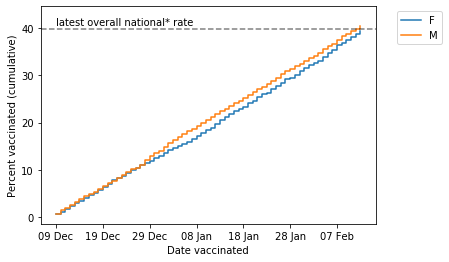

### COVID vaccinations among **80+** population by **ethnicity 6 groups**

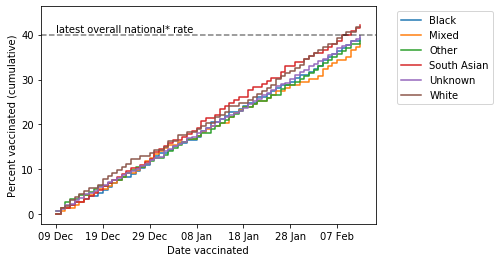

### COVID vaccinations among **80+** population by **imd categories**

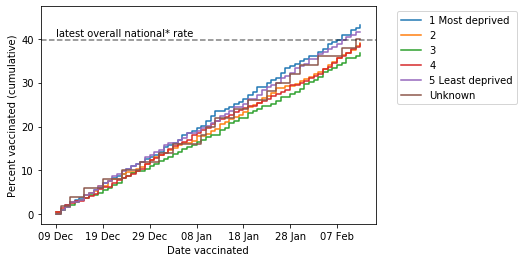

### COVID vaccinations among **80+** population by **bmi**

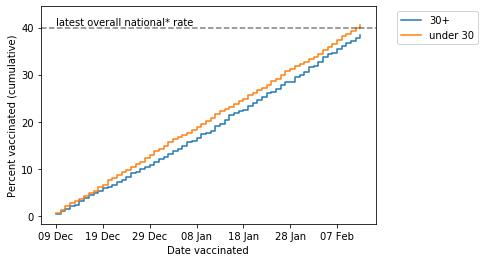

### COVID vaccinations among **80+** population by **chronic cardiac disease**

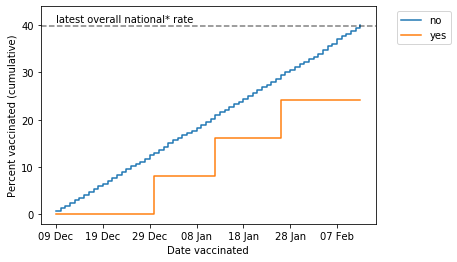

### COVID vaccinations among **80+** population by **current copd**

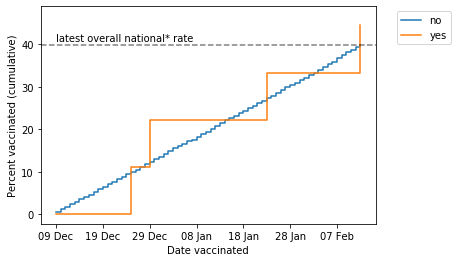

### COVID vaccinations among **80+** population by **dialysis**

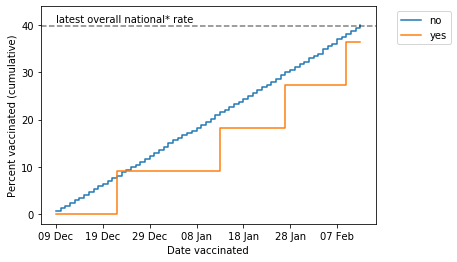

### COVID vaccinations among **80+** population by **dmards**

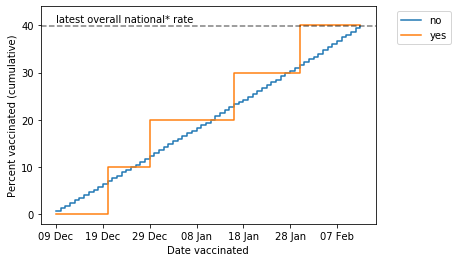

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

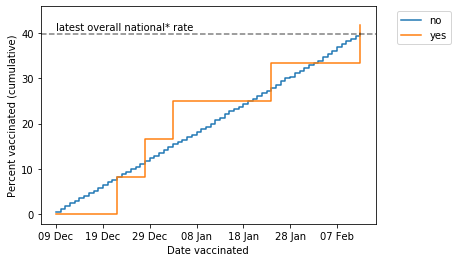

### COVID vaccinations among **80+** population by **intel dis incl downs syndrome**

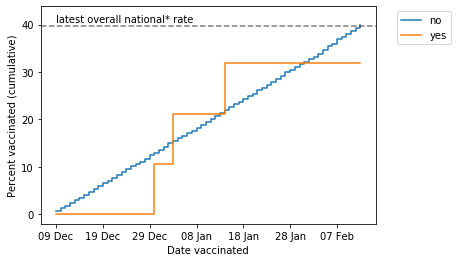

### COVID vaccinations among **80+** population by **dementia**

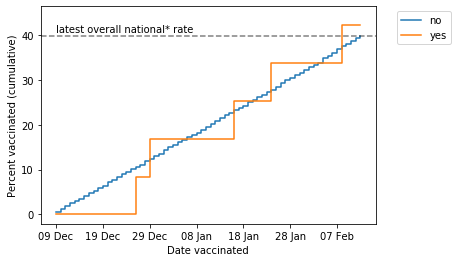

### COVID vaccinations among **80+** population by **ssri**

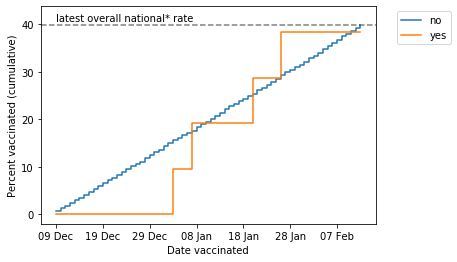

### COVID vaccinations among **80+** population by **chemo or radio**

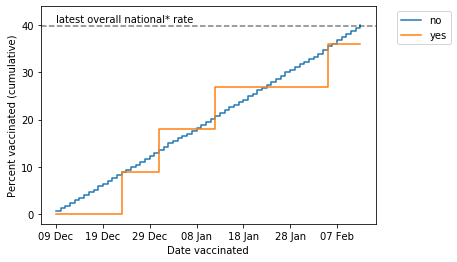

### COVID vaccinations among **80+** population by **lung cancer**

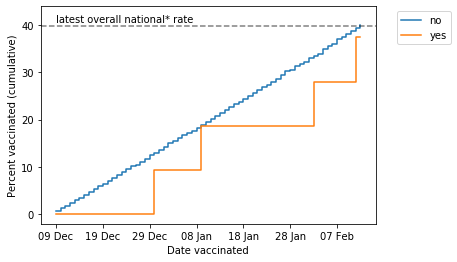

### COVID vaccinations among **80+** population by **cancer excl lung and haem**

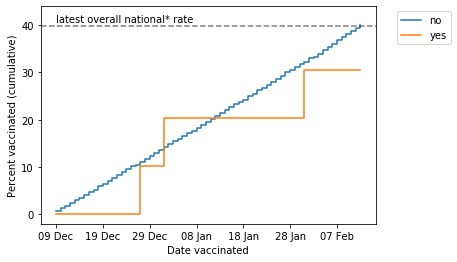

### COVID vaccinations among **80+** population by **haematological cancer**

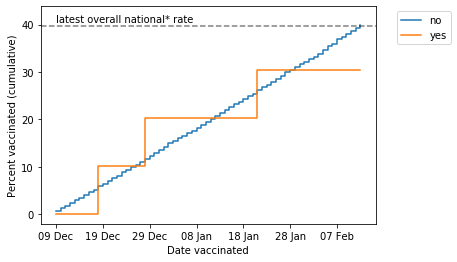

## 
 ## COVID vaccination rollout among **70-79** population up to 12 Feb 2021

### COVID vaccinations among **70-79** population by **sex**

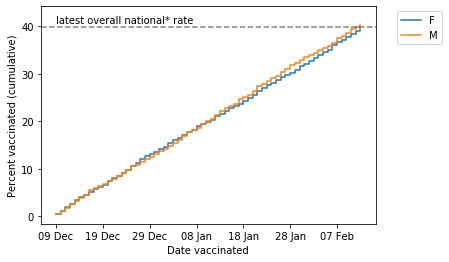

### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

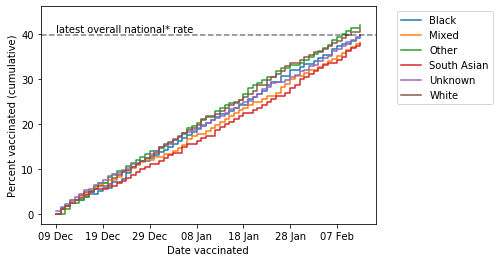

### COVID vaccinations among **70-79** population by **imd categories**

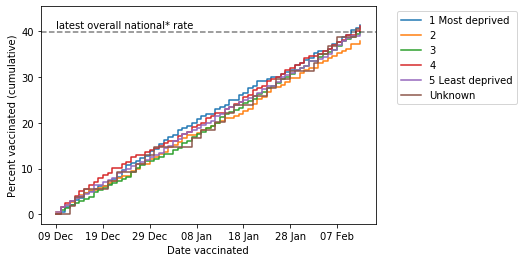

### COVID vaccinations among **70-79** population by **bmi**

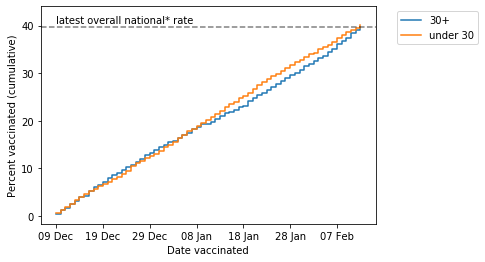

### COVID vaccinations among **70-79** population by **chronic cardiac disease**

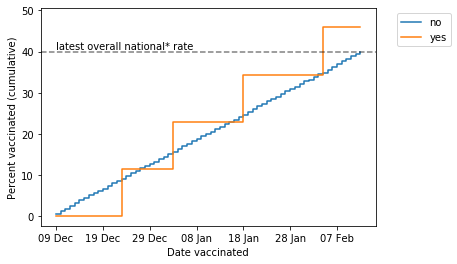

### COVID vaccinations among **70-79** population by **current copd**

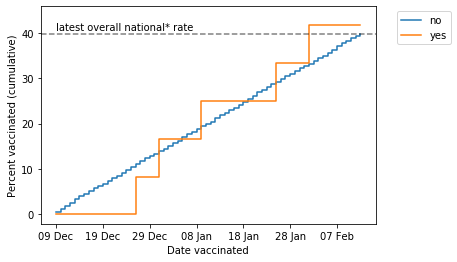

### COVID vaccinations among **70-79** population by **dialysis**

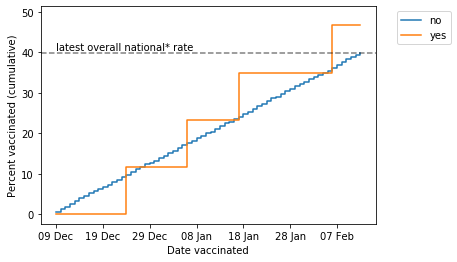

### COVID vaccinations among **70-79** population by **dmards**

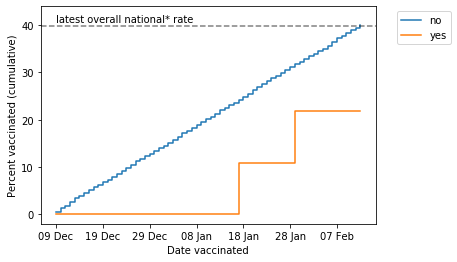

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

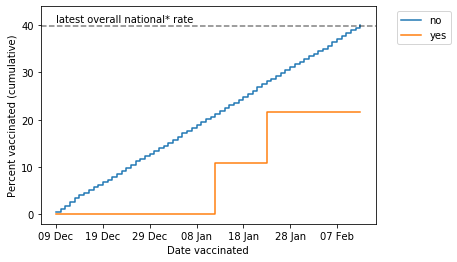

### COVID vaccinations among **70-79** population by **intel dis incl downs syndrome**

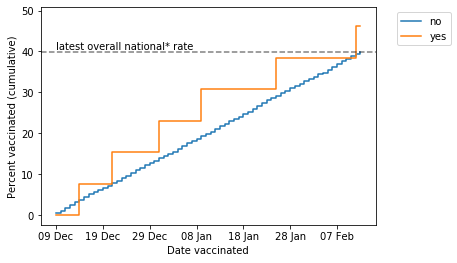

### COVID vaccinations among **70-79** population by **dementia**

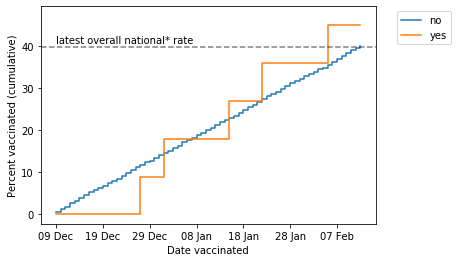

### COVID vaccinations among **70-79** population by **ssri**

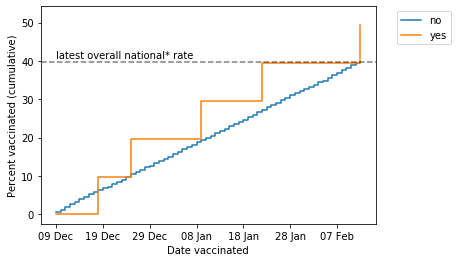

### COVID vaccinations among **70-79** population by **chemo or radio**

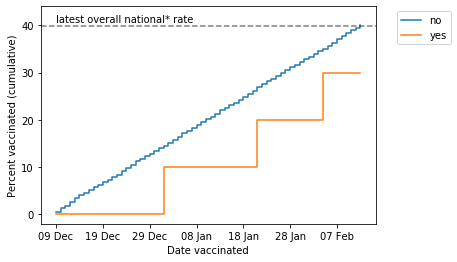

### COVID vaccinations among **70-79** population by **lung cancer**

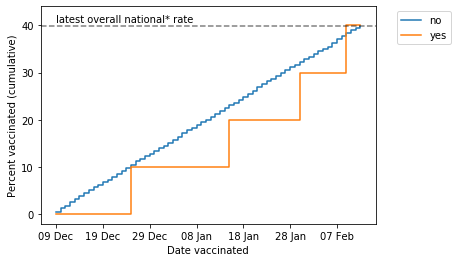

### COVID vaccinations among **70-79** population by **cancer excl lung and haem**

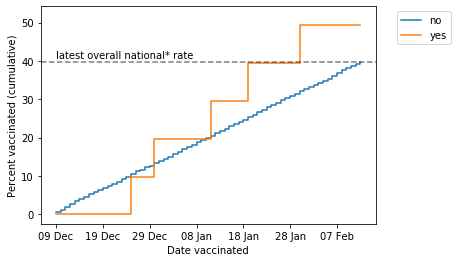

### COVID vaccinations among **70-79** population by **haematological cancer**

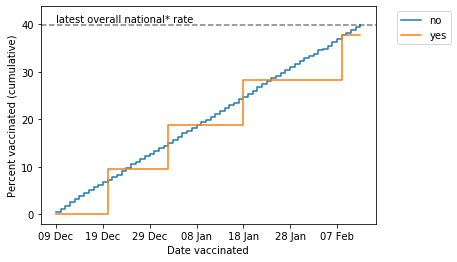

In [21]:
plot_dem_charts(summ_stat_results, df_dict_cum, formatted_latest_date, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [22]:
from data_quality import *

for g in ["80+", "70-79", "care home", "other"]:
    ethnicity_completeness(df, group=g, 
                           name_of_other_group="under 70s, not in other eligible groups shown",
                           groups_not_in_other_group=["care home","80+", "70-79"])

Total **80+** population with ethnicity recorded 5,104 (74.6%)

Total **70-79** population with ethnicity recorded 5,503 (75.1%)

Total **care home** population with ethnicity recorded 830 (73.5%)

Total **under 70s, not in other eligible groups shown** population with ethnicity recorded 26,063 (75.1%)